In [ ]:
import pickle
import torch
import torchvision.models as models
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
os.chdir("../../..")
print(os.getcwd())

In [2]:
with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
    data = pickle.load(file)

## Clustering Plots

In [3]:
# Function to plot clusters on the x, y plane
def plot_clusters(xy_list, cluster_labels):
    """
    Plot the clusters on the x, y plane using the original (x, y) coordinates.
    
    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert xy_list to NumPy arrays for easy plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Check if the lengths match
    if len(x_coords) != len(cluster_labels):
        raise ValueError(f"Mismatch: {len(x_coords)} coordinates and {len(cluster_labels)} cluster labels.")

    # Scatter plot with color coding for clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap='rainbow', alpha=0.7)

    # Add color bar to indicate clusters
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'KMeans Clustering with {len(set(cluster_labels))} Clusters on X-Y Plane')

    # Show the plot
    plt.show()
    
    
def plot_clusters_by_subplots(xy_list, cluster_labels, n_clusters=8):
    """
    Plot the clusters on 8 subplots, one for each cluster, using the original (x, y) coordinates.
    
    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - n_clusters (int): Number of clusters to plot (default is 8).
    """
    # Convert xy_list to NumPy arrays for easy filtering and plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])
    
    # Create subplots (arranged as 4 rows, 2 columns for 8 clusters)
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))  # 4 rows, 2 columns for 8 clusters
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each cluster on its respective subplot
    for cluster_id in range(n_clusters):
        # Get the indices of the datapoints that belong to the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Filter x and y coordinates for the current cluster
        cluster_x = x_coords[cluster_indices]
        cluster_y = y_coords[cluster_indices]
        
        # Scatter plot for the current cluster
        axes[cluster_id].scatter(cluster_x, cluster_y, c=f'C{cluster_id}', alpha=0.7)
        
        # Set subplot title and labels
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel('X Coordinate')
        axes[cluster_id].set_ylabel('Y Coordinate')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Uses ResNET50 to extract features from the images captured by the onboard camera

In [10]:
# Load pre-trained ResNet50 model and remove classification layers for feature extraction
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-2])  # Remove the fully connected layers
resnet50.eval()  # Set model to evaluation mode

torch.set_num_threads(os.cpu_count())
# Function to process a single image and extract features, with additional landmark and orientation data
def process_datapoint(image_tensor, landmarks_binary_list, orientation_radians):
    """
    Process a single image tensor through ResNet50, and augment the features with 
    the binary list of detected landmarks and the robot's orientation.
    
    Args:
    - image_tensor (torch.Tensor): The image tensor from Webots camera.
    - landmarks_binary_list (list of int): Binary list indicating which landmarks are detected in the image.
    - orientation_radians (float): The robot's orientation in radians from the IMU.
    
    Returns:
    - full_features (numpy array): The combined feature vector from ResNet50, landmarks, and orientation.
    """
    with torch.no_grad():
        # Extract ResNet50 features
        features = resnet50(image_tensor.unsqueeze(0))  # Add batch dimension (unsqueeze adds a batch dimension)
        flattened_features = features.view(features.size(0), -1)  # Flatten to [1, 2048 * 7 * 7]
        flattened_features = flattened_features.cpu().numpy().squeeze()  # Convert to NumPy array and remove extra dimensions
    
    # Convert the binary landmark list and orientation to a NumPy array
    landmarks_and_orientation = np.array(landmarks_binary_list + [orientation_radians], dtype=np.float32)
    
    # Concatenate the ResNet features with the landmarks and orientation
    full_features = np.concatenate((flattened_features, landmarks_and_orientation))
    
    return full_features

# Function to extract features from each datapoint, including landmarks and orientation
def extract_features_with_landmarks_and_orientation(dataset):
    """
    Extract features from the dataset one by one, augmenting with landmarks and orientation.
    
    Args:
    - dataset (PovDataset): The dataset containing Datapoint objects.
    
    Returns:
    - features_list (list of numpy arrays): A list of feature vectors for each image in the dataset.
    - xy_labels (list of tuples): A list of (x, y) coordinates corresponding to each feature vector.
    """
    features_list = []
    xy_labels = []
    count = 1
    # Process each datapoint individually
    for datapoint in dataset.data:
        print("Processing data point: ", count)
        count += 1
        # Extract landmarks and orientation (simulated here as placeholders, replace with actual values)
        landmarks_binary_list = datapoint.landmark_mask # Assume this is part of your dataset
        orientation_radians = datapoint.theta  # Assume this is part of your dataset
        
        # Extract features from the image tensor, and include the landmarks and orientation
        features = process_datapoint(datapoint.image_tensor, landmarks_binary_list, orientation_radians)
        features_list.append(features)
        
        # Keep track of the (x, y) coordinates
        xy_labels.append((datapoint.x, datapoint.y))
    
    return features_list, xy_labels

In [11]:
features, xy_list = extract_features_with_landmarks_and_orientation(data)

Processing data point:  1
Processing data point:  2
Processing data point:  3
Processing data point:  4
Processing data point:  5
Processing data point:  6
Processing data point:  7
Processing data point:  8
Processing data point:  9
Processing data point:  10
Processing data point:  11
Processing data point:  12
Processing data point:  13
Processing data point:  14
Processing data point:  15
Processing data point:  16
Processing data point:  17
Processing data point:  18
Processing data point:  19
Processing data point:  20
Processing data point:  21
Processing data point:  22
Processing data point:  23
Processing data point:  24
Processing data point:  25
Processing data point:  26
Processing data point:  27
Processing data point:  28
Processing data point:  29
Processing data point:  30
Processing data point:  31
Processing data point:  32
Processing data point:  33
Processing data point:  34
Processing data point:  35
Processing data point:  36
Processing data point:  37
Processing

KeyboardInterrupt: 

# KMean Clustering

In [5]:
# Function to perform KMeans clustering
def cluster_with_kmeans(features_list, n_clusters):
    """
    Perform KMeans clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for KMeans
    features_array = np.array(features_list)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Set random_state for reproducibility
    cluster_labels = kmeans.fit_predict(features_array)
    
    return cluster_labels

/Users/titonka/FAIRIS/venv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


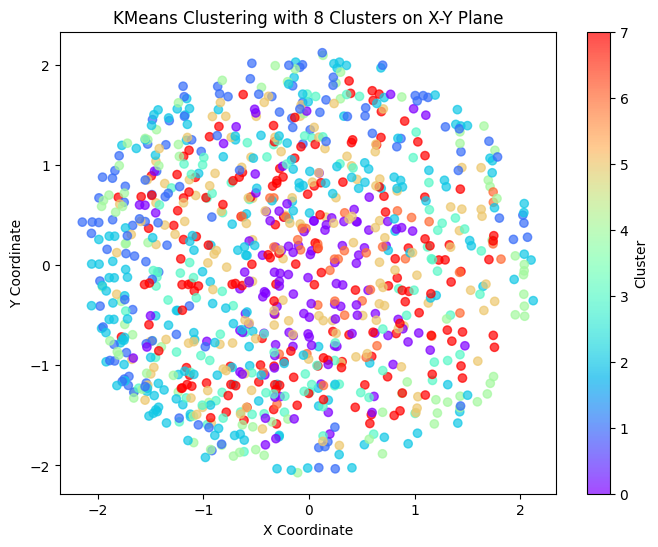

In [6]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_kmeans(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

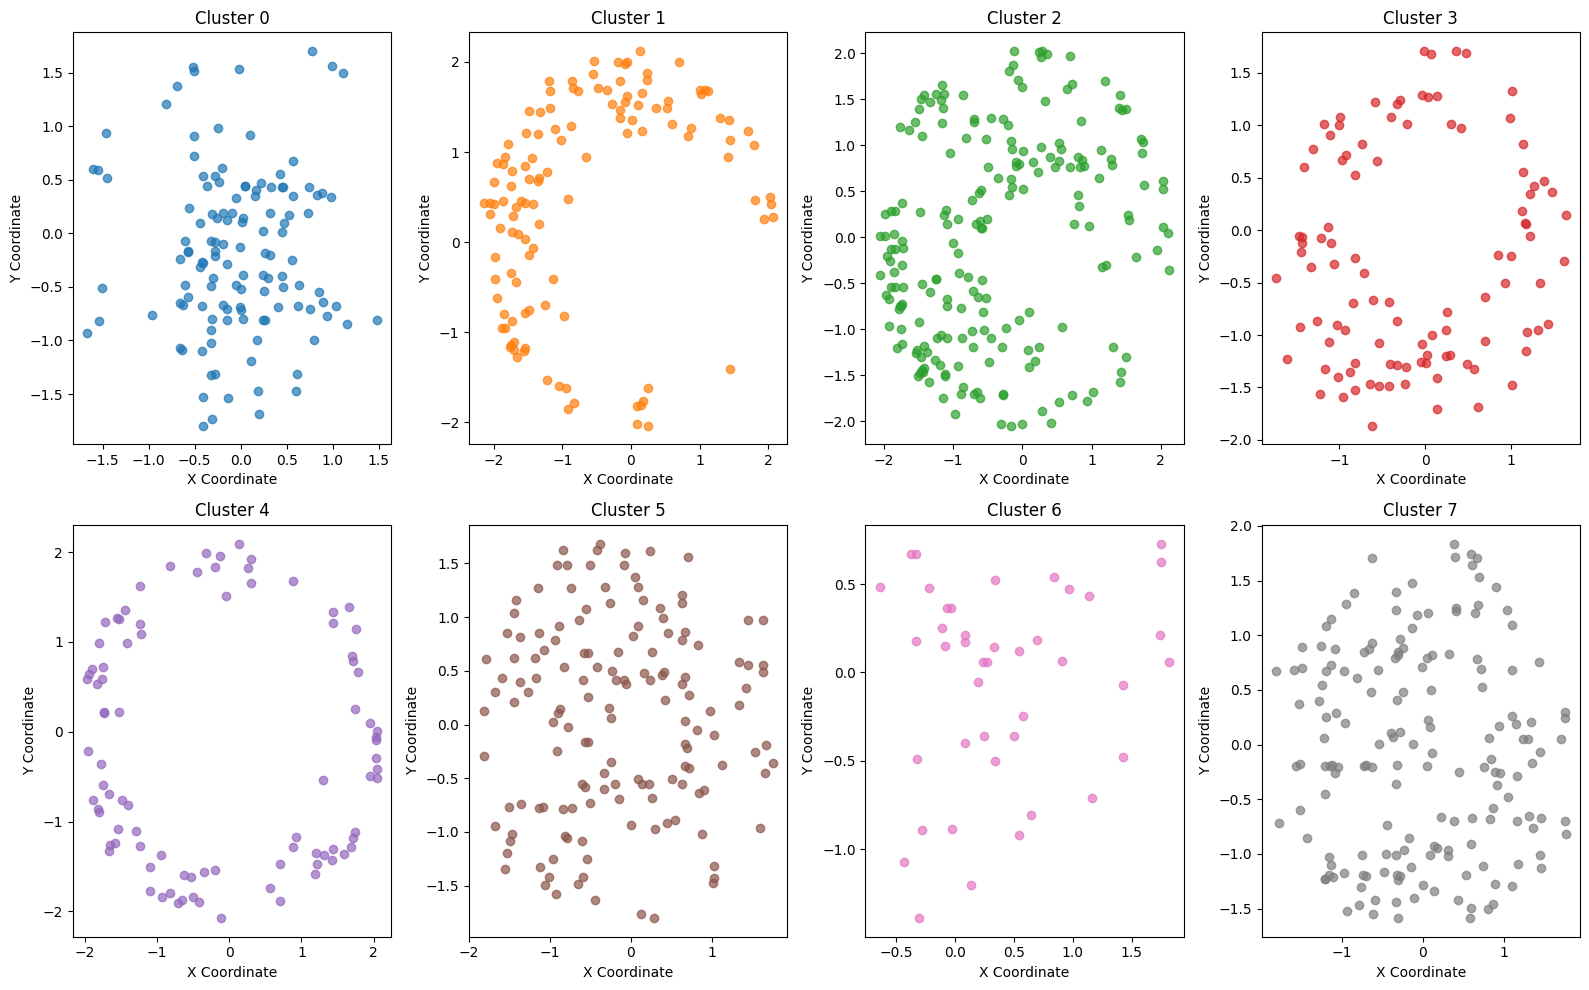

In [7]:
plot_clusters_by_subplots(xy_list, cluster_labels, n_clusters=8)

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
   - How It Works: DBSCAN groups points that are closely packed together, with a minimum number of points in a neighborhood (defined by eps), and marks points that lie in low-density regions (outliers) as noise.
   - When to Use:
        - When you don't know the number of clusters in advance.
        - When your clusters are non-spherical or irregularly shaped.
        - When you want to detect outliers (points that don't belong to any cluster).
   - Pros: Does not require specifying the number of clusters. Can find arbitrarily shaped clusters. Handles noise well.
   - Cons: Sensitive to the choice of eps and min_samples parameters.

In [8]:
def cluster_with_dbscan(features_list, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
    - min_samples (int): The number of samples in a neighborhood for a point to be considered a core point.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint. Points classified as noise are labeled as -1.
    """
    # Convert feature list to a NumPy array for DBSCAN
    features_array = np.array(features_list)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(features_array)
    
    return cluster_labels

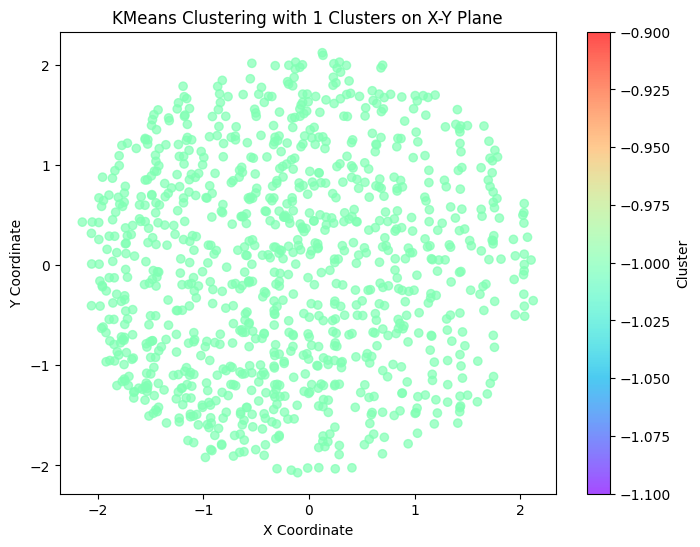

In [9]:
cluster_labels = cluster_with_dbscan(features)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Agglomerative Hierarchical Clustering 
   - How It Works: This method recursively merges pairs of clusters based on the similarity of their points, forming a hierarchy of clusters. You can visualize the clustering process using a dendrogram and then cut the dendrogram to get the desired number of clusters.
   - When to Use:
      - When you want to explore hierarchical structures in your data.
      - When you don't want to specify the number of clusters in advance and want to try different levels of granularity.
   - Pros: Does not require specifying the number of clusters up front. Produces a hierarchy of clusters. Easy to visualize with a dendrogram.
   - Cons: Computationally expensive for large datasets.

In [10]:
def cluster_with_agglomerative(features_list, n_clusters=8):
    """
    Perform Agglomerative Clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for Agglomerative Clustering
    features_array = np.array(features_list)
    
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(features_array)
    
    return cluster_labels

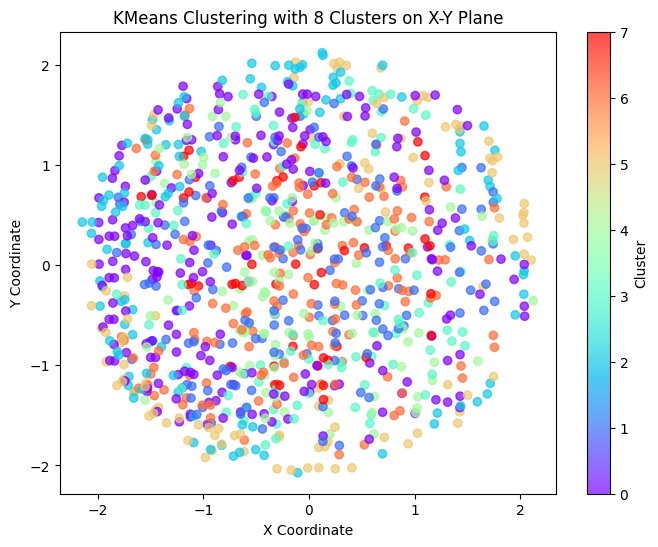

In [11]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_agglomerative(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Spectral Clustering
  - How It Works: Spectral clustering transforms the data into a lower-dimensional space using the eigenvalues of a similarity matrix derived from the data, and then clusters the data in that new space. It is particularly useful for clustering non-linearly separable data.
  - When to Use:
    -  When the data is non-linearly separable, and clusters have complex shapes.
  - Pros: Effective for non-linearly separable data. Can find complex-shaped clusters.
  - Cons: Computationally expensive. Requires predefining the number of clusters.

In [12]:
def cluster_with_spectral(features_list, n_clusters=8):
    """
    Perform Spectral Clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for Spectral Clustering
    features_array = np.array(features_list)
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_array)
    
    return cluster_labels

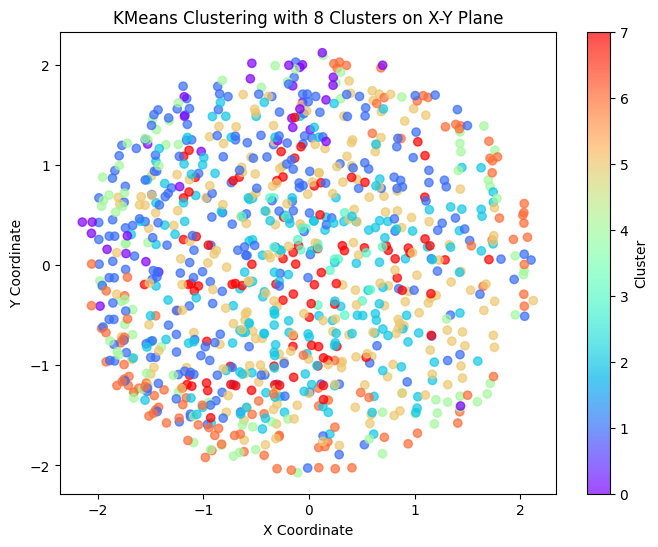

In [13]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_spectral(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Gaussian Mixture Models (GMM)
  - How IT Works:GMM assumes that the data is generated from a mixture of several Gaussian distributions, each with its own mean and variance. The algorithm assigns probabilities to each point belonging to a particular cluster.
  - When to Use:
    -  When you want soft clustering (i.e., points can belong to more than one cluster with a probability).
    -  When you expect your data to follow a Gaussian distribution within each cluster.
  - Pros: Provides probabilistic clustering (soft assignment). Can model more complex cluster shapes.
  - Cons: Requires specifying the number of clusters. Assumes Gaussian distribution of clusters.

In [14]:
def cluster_with_gmm(features_list, n_clusters=8):
    """
    Perform Gaussian Mixture Model (GMM) clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for GMM
    features_array = np.array(features_list)
    
    # Perform GMM clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(features_array)
    cluster_labels = gmm.predict(features_array)
    
    return cluster_labels

In [ ]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_gmm(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Birch (Balanced Iterative Reducing and Clustering using Hierarchies)
  - How it Works: BIRCH builds a tree (called the Clustering Feature Tree) with nodes that summarize information about the data. The tree is then used to perform clustering.
  - When to Use:
    - When you need a memory-efficient clustering technique.
    - When dealing with very large datasets where a single pass over the data is required.
  - Pros: Works well on large datasets. Can be more memory-efficient than other clustering methods.
  - Cons:  Not suitable for non-spherical clusters.

In [ ]:
def cluster_with_birch(features_list, n_clusters=8):
    """
    Perform BIRCH clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for BIRCH
    features_array = np.array(features_list)
    
    # Perform BIRCH clustering
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(features_array)
    
    return cluster_labels

In [ ]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_birch(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)